## Estimation
Performs the Bayesian Estimation in the paper

#### Config

In [ ]:
## load some packages
# estimation
from toolkit.estimation import (
        estimation_G,  # matrix
        log_beta, log_inv_gamma,  # priors
        gen_posterior_prob, get_invhessian,  # number things
        posterior_mode, metropolis_hastings,  # estimation
    )

# model
from models.hankv2 import HANK
from toolkit.irfs import *

# general
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## config
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })
save = False

#### Solve the Model

In [2]:
## intialize model
mod_pars = {
        'gamma': 4., 'chi': 2.,  # household parameters, beta and phi are chosen in calibration
        'N_z': 7, 'rho_z': 0.963, 'sigma_z': 0.134,  # household state transitions
        'kappa': 0.1,  # philips curve
        'kappa_W': 0.1,
        'rho_B': 0.93, 'omega_pi': 1.5, 'omega_Y': 0.,  # govt parameters
        'A': 1., 'psi': 1.2, 'psiW': 1.2, 'g': 0.201, 'xi': 1., 'tauP': 1.18, 'eta': 0.081,  # shock steady states
        'epsA': 1., 'epspsi': 1., 'epspsiW': 1., 'epsg': 1., 'epsxi': 1., 'epstauP': 1., 'epseta': 1.,
        'pi': 1., 'B': 0.577,  # variable steady states we define (otherwise model can't be solved)
        'I': 1.005, 'Y': 1.,  # varaible steady states we target
        'N_a': 501, 'a_min': 0, 'a_max': 50,  # grid states
    }
hank = HANK(**mod_pars)

## solve steady state
free = ['beta', 'phi']
endog = ['R', 'G', 'tauL', 'N', 'M', 'D', 'piW', 'L', 'curlN', 'curlC', 'curlB']
markets = {m: HANK.markets[m] for m in ['mkt3', 'mkt4']}  # the other markets clear by definition or by an analytic form
V_a0 = (hank.a_grid[:, None] * (hank.I - 1) + hank.z_grid)**(-hank.gamma)
X0 = np.array([0.9, 0.1])
hank.solve_ss(free, endog, V_a0, X0, markets=markets)
assert np.isclose(hank.curlC + hank.G - hank.Y, 0)  # walras

## solve for perturbation matrix
T = 300
G, dxs = hank.solve_G(T, ha=True, h=1e-4)

f'phi = {hank.phi}; beta = {hank.beta}'

'phi = 3.1554601309064183; beta = 0.944885031287334'

#### Data
Multiply it by the steady state values bc the model works in real, not %, terms.

In [3]:
## read data, creates in make_data.ipynb
df = pd.read_csv('data/data.csv')

# make it levels of model values
df['Y'] *= hank.Y
df['C'] *= hank.curlC
df['G'] *= hank.G
df['B'] *= hank.B
df['W'] *= hank.W
df['N'] *= hank.N
df['pi'] *= hank.pi
df['I'] *= hank.I

#### Mode-Finding

In [4]:
## Setup
outputs = np.array(['Y', 'pi', 'I', 'N', 'B', 'curlC', 'W'])  # outputs we estimate off of
est_outputs = np.where(outputs == 'curlC', 'C', outputs)  # rename 'curlC' to align with data df
priors = (
        [lambda x: log_beta(x, 0.5, 0.15) for _ in range(7)]  # ar1 coeffs
        + [lambda x: log_inv_gamma(x, 0.1, 2) for _ in range(7)]  # standard deviations
    )
est_G = estimation_G(G, outputs=outputs)  # make the G matric used in estimation, just concatenated version of G
drawf = gen_posterior_prob(est_G, df[np.where(outputs == 'curlC', 'C', outputs)].values, priors)  # evaluate log-liklihood

## posterior mode
res = posterior_mode(drawf, 7, X0=np.hstack((0.5 * np.ones(7), 0.1 * np.ones(7))), tol=1e-4)
assert res.success
mode = res.x  # get the mode values
invH = get_invhessian(drawf, mode)  # used to make draws in MCMC

#### Metropolis Hastings

In [5]:
## MCMC
bounds = np.array([(0, 1) for _ in range(hank.N_z)] + [(0, np.inf) for _ in range(hank.N_z)]).T
N_sim = 250000  # takes ~3 min per 10k
N_burn = 50000
np.random.seed(0)
sim_res, logposterior, accept_rate = metropolis_hastings(drawf, mode, invH, bounds, N_sim, N_burn)
print(f'Accept Rate: {accept_rate * 100:.2f}%')

## get results
means = np.mean(sim_res[N_burn:], axis=0)  # mean
conf_int = np.percentile(sim_res[N_burn:], [5, 95], axis=0)  # confidence interval

## collect results
res_df = pd.DataFrame(
        data=np.vstack((mode, means, conf_int)).T[np.vstack((np.arange(hank.N_z), hank.N_z + np.arange(hank.N_z))).ravel('F')],
        columns=['mode', 'mean', '5%', '95%'],
        index=np.ravel([(f'rho_{s}', f'sigma_{s}') for s in hank.shocks]),
    )
if save: res_df.to_csv('data/bayes_results.csv')
res_df

Accept Rate: 22.57%


,mode,mean,5%,95%
rho_epsA,0.952359,0.951955,0.934476,0.968880
sigma_epsA,0.152328,0.153505,0.141666,0.166392
rho_epspsi,0.987360,0.982902,0.970132,0.991489
sigma_epspsi,0.548628,0.557935,0.510669,0.611016
rho_epspsiW,0.996699,0.996649,0.996098,0.997177
sigma_epspsiW,1.760922,1.764530,1.620959,1.921265
rho_epsg,0.849814,0.856007,0.806853,0.905533
sigma_epsg,0.648263,0.652244,0.602601,0.707387
rho_epsxi,0.633600,0.627204,0.574172,0.678079
sigma_epsxi,0.439936,0.444003,0.409164,0.481417


#### Recursive Means

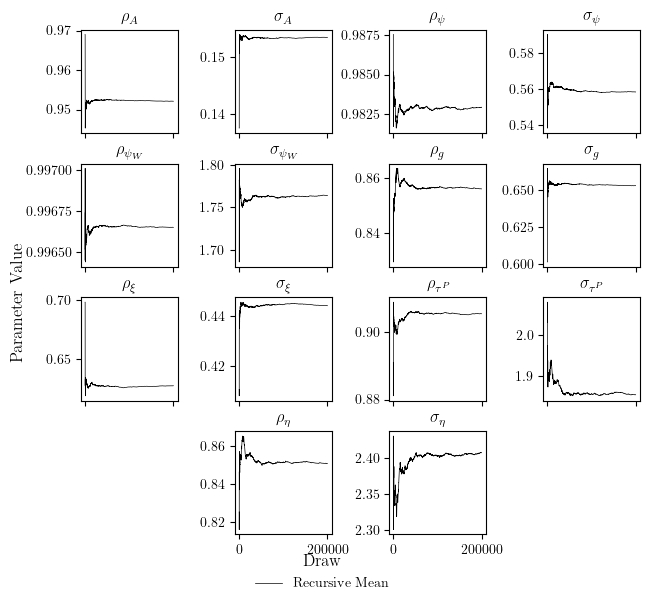

In [6]:
# setup plot
fig, axs = plt.subplots(4, 4, sharex=True)
fig.set_figwidth(6.5)
fig.set_figheight(6)
fig.supxlabel('Draw', y=1/20 * 8/7)
fig.supylabel('Parameter Value')
axs[-1, 0].set_axis_off()
axs[-1, -1].set_axis_off()
axs = np.delete(axs.ravel(), [12, 15])

# plot them all
shock_labels = ['A', r'\psi', r'{\psi_W}', 'g', r'\xi', r'{\tau^P}', r'\eta']
for i in range(hank.N_z):
    # plot rho
    ax = axs[2 * i]
    ax.set_title(rf'$\rho_{shock_labels[i]}$')
    recursive_mean = sim_res[:, i].cumsum() / np.arange(1, 1 + sim_res.shape[0])
    ax.plot(recursive_mean, 'k-', linewidth=0.5)

    # plot sigma
    ax = axs[2 * i + 1]
    ax.set_title(rf'$\sigma_{shock_labels[i]}$')
    recursive_mean = sim_res[:, hank.N_z + i].cumsum() / np.arange(1, 1 + sim_res.shape[0])
    tln, = ax.plot(recursive_mean, 'k-', linewidth=0.5, label='Recursive Mean')

## make the figure
fig.tight_layout(pad=0.5)
fig.subplots_adjust(bottom=1/10 * 8/7)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False, handles=[tln], ncols=2)
if save: fig.savefig('paper/figures/recursive_means.pgf')

#### Posterior Distrtibutions

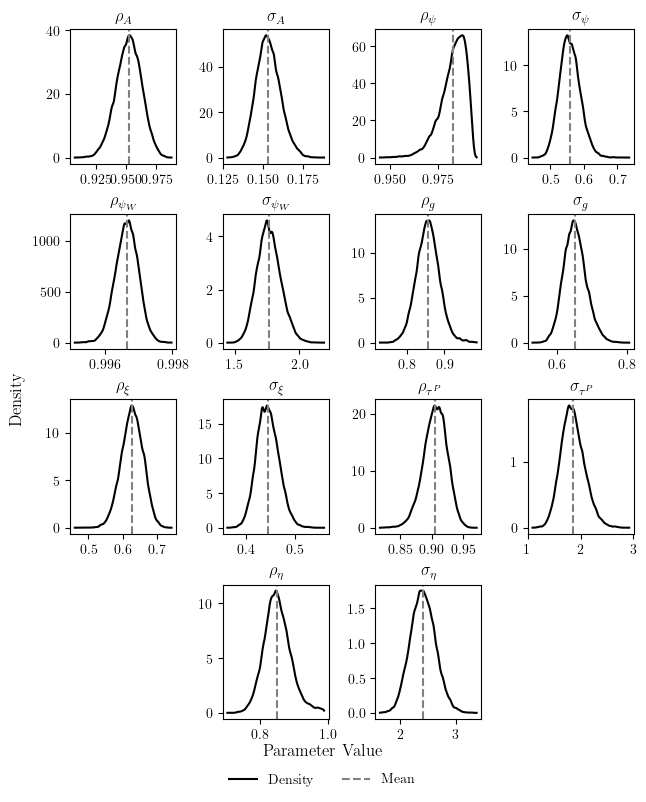

In [7]:
## posteriors plot
# setup plot
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(6.5)
fig.set_figheight(8)
fig.supxlabel('Parameter Value', y=1/20)
fig.supylabel('Density')
axs[-1, 0].set_axis_off()
axs[-1, -1].set_axis_off()
axs = np.delete(axs.ravel(), [12, 15])

# plot them all
shock_labels = ['A', r'\psi', r'{\psi_W}', 'g', r'\xi', r'{\tau^P}', r'\eta']
maxs = sim_res.max(axis=0)
mins = sim_res.min(axis=0)
for i in range(hank.N_z):
    # plot rho
    ax = axs[2 * i]
    ax.set_title(rf'$\rho_{shock_labels[i]}$')
    kde = gaussian_kde(sim_res[:, i])
    x = np.linspace(mins[i], maxs[i], 250)
    ax.plot(x, kde(x), c='k')

    # means
    ax.axvline(means[i], linestyle='--', color='gray')

    # plot sigma
    ax = axs[2 * i + 1]
    ax.set_title(rf'$\sigma_{shock_labels[i]}$')
    kde = gaussian_kde(sim_res[:, hank.N_z + i])
    x = np.linspace(mins[hank.N_z + i], maxs[hank.N_z + i], 250)
    dln, = ax.plot(x, kde(x), c='k', label='Density')

    # means
    mln = ax.axvline(means[hank.N_z + i], linestyle='--', color='gray', label='Mean')

## make the figure
fig.tight_layout(pad=0.75)
fig.subplots_adjust(bottom=1/10)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False, handles=[dln, mln], ncols=2)
if save: fig.savefig('paper/figures/posteriors.pgf')

#### Triangle Plot

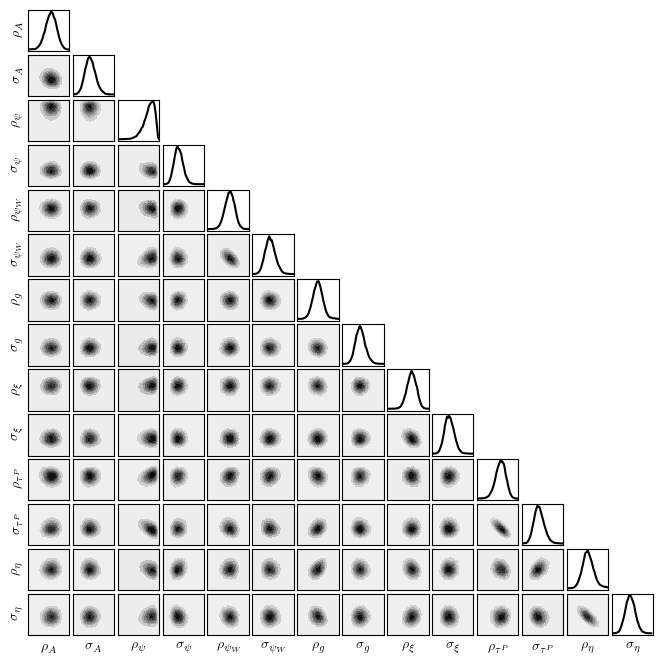

In [8]:
## triangle plot
# setup plot
fig, axs = plt.subplots(2 * hank.N_z, 2 * hank.N_z, sharex='col')
fig.set_figheight(6.5)
fig.set_figwidth(6.5)
for ax in axs[np.triu_indices(2 * hank.N_z, k=1)]:
    ax.set_axis_off()

# single variable things
labels = [
        r'$\rho_A$', r'$\sigma_A$', r'$\rho_\psi$', r'$\sigma_\psi$',
        r'$\rho_{\psi_W}$', r'$\sigma_{\psi_W}$', r'$\rho_g$', r'$\sigma_g$',
        r'$\rho_\xi$', r'$\sigma_\xi$', r'$\rho_{\tau^P}$', r'$\sigma_{\tau^P}$',
        r'$\rho_\eta$', r'$\sigma_\eta$',
    ]
order = np.vstack((np.arange(hank.N_z), hank.N_z + np.arange(hank.N_z))).ravel('F')
maxs = sim_res.max(axis=0)
mins = sim_res.min(axis=0)
for i, s in enumerate(order):
    # formatting
    axs[i, i].set_xticks([])
    axs[i, i].set_yticks([])

    # density plot
    kde = gaussian_kde(sim_res[:, s])
    x = np.linspace(mins[s], maxs[s], 250)
    axs[i, i].plot(x, kde(x), c='k')

    # axis labels
    axs[-1, i].set_xlabel(labels[i])
    axs[i, 0].set_ylabel(labels[i])

# two variable things
for i, s1 in enumerate(order):
    for j, s2 in enumerate(order[:i]):
        # formatting
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].sharey(axs[i, 0])

        # density
        kde = gaussian_kde(sim_res.T[[s2, s1]])
        x, y = np.meshgrid(np.linspace(mins[s2], maxs[s2], 100), np.linspace(mins[s1], maxs[s1], 100))
        kdef = np.reshape(kde(np.vstack((x.ravel(), y.ravel()))), x.shape)
        axs[i, j].contourf(x, y, kdef, cmap='binary')

# final things
fig.tight_layout(pad=0.25)
if save: fig.savefig('paper/figures/triangle.pgf')